In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Balanced

In [2]:
separated_means = [[-3, 2], [-1.5, 2], [0, 2], [1.5, 2], [3, 2], [-3, 0], [-1.5, 0], [0, 0], [1.5, 0], [3, 0]]
overlapped_means = [[-2, 1], [-1.5, 1], [0, 1], [1.5, 1], [2, 1], [-2, 0], [-1.5, 0], [0, 0], [1.5, 0], [2, 0]]
highly_overlapped_means = [[-2, 1], [-1.5, 1], [-1, 1], [-0.5, 1], [0, 1], [-2, 0], [-1.5, 0], [-1, 0], [-0.5, 0], [0, 0]]

In [3]:
size_per_category = 1000

In [4]:
palette = ['red', 'green', 'blue', 'cyan', 'magenta', 'orange', 'yellow', 'lightgreen', 'skyblue', 'orchid']

In [5]:
def generate_distribution(mean_array, size_per_category):
    points = pd.DataFrame()
    x = []
    y = []
    category = []
    index = 0
    for mean in mean_array:
        gaussian_normal_points = np.random.normal(loc=mean, scale=[0.3,0.3], size=[size_per_category, 2])
        x += list(gaussian_normal_points[:, 0])
        y += list(gaussian_normal_points[:, 1])
        category += [index] * size_per_category
        index += 1
    points['x'] = x
    points['y'] = y
    points['category'] = category
    return points

In [6]:
def plot_distribution(distribution):
    legend = [('Category '+ str(index+1)) for index in range(10)]
    plt.figure(figsize=(15,8))
    for index in range(10):
        data = distribution[distribution['category'] == index]
        plt.scatter(data['x'], data['y'], c=palette[index], s=5)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend((legend), loc=1)

In [7]:
separated = generate_distribution(separated_means, size_per_category)
#plot_distribution(separated)

In [8]:
overlapped = generate_distribution(overlapped_means, size_per_category)
#plot_distribution(overlapped)

In [9]:
highly_overlapped = generate_distribution(highly_overlapped_means, size_per_category)
#plot_distribution(highly_overlapped)

# Imbalanced

Run for r in [0.01, 0.05, 0.1, 0.5, 0.9] and m in [1,9]

Simulating for one test case:

In [10]:
m = 2
r = 0.01
k = 10
imbalanced_size = 2000

In [11]:
def sample_imbalanced_data(data, imbalanced_size, m, r, k):
    p_min = r/10 #for m classes
    p_max = (1 - (p_min * m))/(k - m) #for k-m classes
    minority_positions = ([p_min] * m + [p_max] * (k - m))
    np.random.shuffle(minority_positions)
    class_probabilities = [(proba/size_per_category) for proba in minority_positions]
    p = [class_probabilities[category] for category in data['category']]
    indices = np.arange(len(data))
    selected_indices = np.random.choice(indices, imbalanced_size, p=p)
    imbalanced_samples = data.iloc[selected_indices, :]
    imbalanced_samples.reset_index(inplace=True, drop=True)
    return imbalanced_samples

In [12]:
separated_imbalanced = sample_imbalanced_data(separated, imbalanced_size, m, r, k)
#plot_distribution(separated_imbalanced)

In [13]:
overlapped_imbalanced = sample_imbalanced_data(overlapped, imbalanced_size, m, r, k)
#plot_distribution(overlapped_imbalanced)

In [14]:
highly_overlapped_imbalanced = sample_imbalanced_data(highly_overlapped, imbalanced_size, m, r, k)
#plot_distribution(highly_overlapped_imbalanced)

In [15]:
def imbalance_ratio(data):
    value_counts = data['category'].value_counts()
    counts = [count for category, count in value_counts.iteritems()]
    count_max = max(counts)
    count_min = min(counts)
    IR = count_max / count_min
    return IR

In [16]:
imbalance_ratio(separated_imbalanced)

287.0

In [17]:
def hellinger_distance(vec1, vec2):
    return np.sqrt(np.sum((np.sqrt(vec1) - np.sqrt(vec2)) ** 2)) / np.sqrt(2)

In [18]:
def imbalance_degree(data, c):
    value_counts = data['category'].value_counts()
    counts = [count for category, count in value_counts.iteritems()]
    size = len(data)
    p = np.array(counts) / size
    if (len(p) < c):
        p = np.concatenate((p, [0] * (c-len(p))))
    b = [1/c] * c
    m = 0
    for prob in (p-b):
        if prob < 0:
            m +=1
    p_m = [0] * m + [1/c] * (c-m-1) + [1-(c-m-1)/c]
    ID = (hellinger_distance(p,b) / hellinger_distance(p_m,b)) + (m-1)
    return ID

In [19]:
imbalance_degree(overlapped_imbalanced, k)

1.8082805191866032

In [20]:
def log_likelihood_index(data):
    c = len(np.unique(data['category']))
    value_counts = data['category'].value_counts()
    size = len(data)
    proba = [(count/size) for category, count in value_counts.iteritems()]
    summation = np.sum([(p*np.log(p*c)) for p in proba])
    LLI = 2 * summation
    return LLI

In [21]:
log_likelihood_index(separated_imbalanced)

0.4414705008572489

# Simulating for all values

In [22]:
def compute_graphs(distribution, imbalanced_size, k):
    results = []
    for m in range(1,k):
        IR = []
        ID = []
        LLI = []
        for r in [0.01, 0.05, 0.1, 0.5, 0.9]:
            imbalanced_data = sample_imbalanced_data(distribution, imbalanced_size, m, r, k)
            IR.append(imbalance_ratio(imbalanced_data))
            ID.append(imbalance_degree(imbalanced_data, k))
            LLI.append(log_likelihood_index(imbalanced_data))
        result = {}
        result['ir'] = IR
        result['id'] = ID
        result['lli'] = LLI
        results.append(result)
    return results

In [23]:
def plot_graph(distribution, metric, legend, k=10, imbalanced_size=5000):
    data_points = compute_graphs(distribution, imbalanced_size, k)
    #plt.figure(figsize=(10,6))
    index = 0
    r_values = [0.01, 0.05, 0.1, 0.5, 0.9]
    legend = [('m = ' + str(i)) for i in range(1,10)]
    for category in data_points:
        scores = category[metric]
        plt.plot(r_values, scores)
        plt.xlabel('r')
        plt.ylabel(metric.upper())
        print(scores)
    plt.legend((legend), loc=1, fontsize='medium', framealpha=0.2)

[0.19971421427186972, 0.1690024101975275, 0.1368724477792535, 0.032801436926146996, 0.003336005448970572]
[0.42977892833737735, 0.36534954033233974, 0.30653049632511065, 0.08774547282639698, 0.004205224979374405]
[0.686545126463402, 0.5778725301869249, 0.5078789548266696, 0.12597131726395794, 0.005907405132796809]
[0.9741222123231361, 0.8292457966185032, 0.7428246485036576, 0.19171857425885963, 0.009733733008450398]
[1.3206913465057946, 1.1326011372328442, 1.0254389367512877, 0.25996357835064343, 0.013065621334613226]
[1.7427866661563156, 1.5099968342332006, 1.3065964733433442, 0.354346311735217, 0.019219501633158692]
[2.293487277421353, 2.0233685980824587, 1.7574224077823921, 0.5083305665778386, 0.03025850810211858]
[3.120767563165834, 2.8120762574754194, 2.469069123667849, 0.7524572797799793, 0.04105063543604333]
[4.450889722735083, 4.125209261555479, 3.5468359926092408, 1.2588855810061197, 0.058068780140030515]


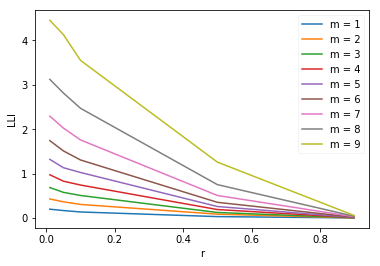

In [24]:
plot_graph(highly_overlapped, 'lli', legend=True)

[0.1985844221736917, 0.18385129909014858, 0.14114322690953424, 0.03717231199918036, 0.0063479783409775975]
[0.4213824112057192, 0.37348291716367116, 0.3117083126446829, 0.07557303970390233, 0.003654964813668435]
[0.6947394312249636, 0.5847755612328862, 0.48357913941875935, 0.12511838247667983, 0.005252333866130412]
[0.9674088478412436, 0.809049568806957, 0.7218007601557876, 0.19809968640625975, 0.007916890635577819]
[1.3364373930587785, 1.144166452346188, 0.9635852649667109, 0.2573263132808626, 0.009718009629063929]
[1.7495389395035887, 1.5551825191761017, 1.3289439371427514, 0.33620010777174875, 0.013646749745433218]
[2.337431839621303, 2.0538377867691, 1.807912365162958, 0.5223667543439218, 0.02726232869669882]
[3.112437155924911, 2.7724561382833213, 2.4606667270412945, 0.7677020237456134, 0.03236903174882419]
[4.459768697297714, 4.018591905339443, 3.640284101640011, 1.192933951847358, 0.09198682492391552]


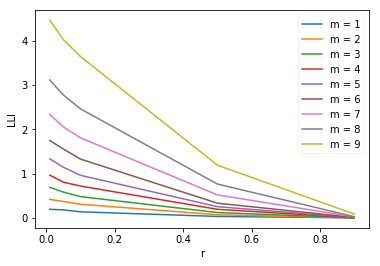

In [25]:
plot_graph(overlapped, 'lli', legend=True)

[0.20579103219241976, 0.17446867742412892, 0.14363011914779486, 0.036712387534265034, 0.0034353100362286837]
[0.4246996332087946, 0.3708010610865888, 0.30860341490589116, 0.06671213797461764, 0.0017981616941196849]
[0.6808441720849894, 0.5846153370272213, 0.4864989485991376, 0.11732383780092541, 0.006426807472231212]
[0.9837044008670868, 0.8365070162094492, 0.7134558151014636, 0.18163422874985957, 0.0073792018855199475]
[1.3295055357589654, 1.1705259482371106, 0.977475678555432, 0.2510828193914885, 0.009906702351867941]
[1.7610068368380423, 1.5516420044763837, 1.3403763504607062, 0.3603821339189097, 0.01634330163542467]
[2.2861118673463667, 2.0887299592429533, 1.7894455758714483, 0.5115750137426122, 0.01753927442118657]
[3.1095495447941537, 2.7969355840107815, 2.4858270426928435, 0.762053900847786, 0.03462690017617215]
[4.455745498102755, 4.069639043947882, 3.547871354910149, 1.1979950182286172, 0.0658186875733191]


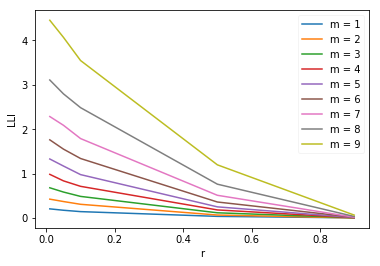

In [26]:
plot_graph(separated, 'lli', legend=True)